# MAST Table Access Protocol Hubble Source Catalog Demo

<br> This tutorial demonstrates how to use astroquery to access the Hubble Source Catalog (HSC) via a Virtual Observatory standard Table Access Protocol (TAP) service at MAST, and work with the resultant data. 

***
### Table of Contents

1. [HSC TAP Service Introduction](#HSC-TAP-Service-Introduction)
2. [Imports](#Imports)
3. [Connecting, Finding, and Displaying Table Information](#Connecting,-Finding,-and-Displaying-Table-Information)
    - [Connecting to a TAP Service](#Connecting-to-a-TAP-Service)
    - [Querying for Table Schema Information](#Querying-for-Table-Schema-Information)
    - [Querying for Data](#Querying-for-Data)
    - [Use Case: Plotting a light curve for the most variable object in a field](#Use-Case:-Plotting-a-light-curve-for-the-most-variable-object-in-a-field)
    - [Use Case: Create a color magnitude diagram for the Small Magellanic Cloud](#Use-Case:-Create-a-color-magnitude-diagram-for-the-Small-Magellanic-Cloud) <br><br>
4. [Additional Resources](#Additional-Resources)
5. [About This Notebook](#About-this-Notebook)
***

## HSC TAP Service Introduction

Table Access Protocol (TAP) services allow more direct and flexible access to astronomical data than the simpler types of IVOA standard data services. Queries are built with the SQL-like Astronomical Data Query Language (ADQL), and can include geographic/spatial queries as well as filtering on other characteristics of the data. This also allows the user fine-grained control over the returned columns, unlike the fixed set of coumns returned from cone, image, and spectral services.

For this example, we'll be using the astropy affiliated PyVO client, which is interoperable with other valid TAP services, including those at MAST. PyVO documentation is available at ReadTheDocs: https://pyvo.readthedocs.io

We'll be using PyVO to call the most recent version (3) of the Hubble Source Catalog TAP service at MAST. The schema is described within the service, and we'll show how to inspect it. The schema is also the same as the one available via the CasJobs interface, with an additional view added for the most common positional queries. CasJobs has its own copy of the schema documentation, which can be accessed through its own site: http://mastweb.stsci.edu/hcasjobs/



***
## Imports

In [1]:
import pyvo as vo

## For handling ordinary astropy Tables in responses
from astropy.table import Table

# For displaying and manipulating some types of results
%matplotlib inline
import requests
import astropy
import numpy as np
import time
from matplotlib import pyplot as plt

# For the second example: kernel density estimates
from scipy.stats import gaussian_kde


# suppress unimportant unit warnings from many TAP services
import warnings
warnings.filterwarnings("ignore", module="astropy.io.votable.*")

***
## Connecting, Finding, and Displaying Table Information 

### Connecting to a TAP Service

The PyVO library is able to connect to any TAP service, given the "base" URL as noted in metadata registry resources describing the service. This is the URL for the newest version of the Hubble Source Catalog TAP service.

In [2]:
HSC_service = vo.dal.TAPService("https://mast.stsci.edu/vo-tap/api/v0.1/hsc/")

### Querying for Table Schema Information
    
TAP services are self-describing, which means the service itself can be asked for its schema and documentation about it. Since the Hubble Source Catalog does not follow a data model described by a standard, this is the best way to see what tables and columns we have available to then query based on geometry or other filters. 
    
Note that several views for HSC, including the main science table SumMagAper2CatView, are extremely wide, containing columns for all potential filters, each of which may have null data. The ability to filter queries based on only columns we want, or that aren't null, makes TAP services more flexible and potentially faster.

In [3]:
HSC_service.describe()

Capability ivo://ivoa.net/std/TAP

Interface vs:ParamHTTP
    https://mast.stsci.edu/vo-tap/api/v0.1/hsc

Language ADQL
    ivo://ivoa.net/std/TAPRegExt#features-adqlgeo
        CONTAINS

        POINT

        CIRCLE

        BOX


Output format application/json
    Also available as json

Output format text/csv;header=present
    Also available as csv

Output format application/xml
    Also available as xml

Output format application/x-votable+xml
    Also available as votable

Maximum size of resultsets
    Default 100000 row
    Maximum 100000 row


Capability ivo://ivoa.net/std/DALI#examples

Interface vr:WebBrowser
    https://mast.stsci.edu/vo-tap/api/v0.1/hsc/examples




In [4]:
HSC_tables = HSC_service.tables
for tablename in HSC_tables.keys():
    if not "tap_schema" in tablename:  
        # No descriptions are available for these tables; this will just print the name
        HSC_tables[tablename].describe() 
        print("Columns={}".format(sorted([k.name for k in HSC_tables[tablename].columns ])))
        print("----")

dbo.detailedcatalog
    Detailed list of source catalog parameters

Columns=['abscorr', 'aperture', 'catid', 'ci', 'd', 'det', 'detector', 'dsigma', 'exposuretime', 'filter', 'flags', 'fluxaper2', 'imageid', 'imagename', 'instrument', 'kronradius', 'magaper2', 'magauto', 'matchdec', 'matchid', 'matchra', 'memid', 'mode', 'propid', 'sourcedec', 'sourceid', 'sourcera', 'startmjd', 'starttime', 'stopmjd', 'stoptime', 'targetname', 'wavelength', 'ximage', 'yimage']
----
dbo.hcvdetailedview
    Detailed list of Hubble Catalog of Variables parameters

Columns=['ci', 'corrmag', 'd', 'filter', 'imagename', 'mag', 'magerr', 'matchid', 'mjd']
----


dbo.hcvsummaryview
    Summary list of Hubble Catalog of Variables parameters

Columns=['autoclass', 'chi2', 'dec', 'expertclass', 'filter', 'filterdetflag', 'groupid', 'mad', 'matchid', 'meancorrmag', 'meanmag', 'numlc', 'ra', 'subgroupid', 'varqualflag']
----
dbo.propermotionsview
    List of proper motion information

Columns=['ci', 'ci_sigma', 'decmean', 'decmeanerr', 'dsigma', 'epochend', 'epochmean', 'epochstart', 'htmid', 'kronradius', 'kronradius_sigma', 'latmean', 'latmeanerr', 'lonmean', 'lonmeanerr', 'numfilters', 'numimages', 'numsources', 'numvisits', 'objid', 'pmdec', 'pmdecdev', 'pmdecerr', 'pmlat', 'pmlatdev', 'pmlaterr', 'pmlon', 'pmlondev', 'pmlonerr', 'pmra', 'pmradev', 'pmraerr', 'ramean', 'rameanerr', 'x', 'y', 'z']
----
dbo.sourcepositionsview
    List of source position information

Columns=['ddec', 'dec', 'dlat', 'dlon', 'dra', 'dt', 'epochmean', 'lat', 'lon', 'matchid', 'objid', 'ra', 'sourceid']
----


dbo.summagaper2catview
    Summary list of source catalog with Aper2 magnitudes

Columns=['a_f435w', 'a_f435w_mad', 'a_f435w_n', 'a_f475w', 'a_f475w_mad', 'a_f475w_n', 'a_f502n', 'a_f502n_mad', 'a_f502n_n', 'a_f550m', 'a_f550m_mad', 'a_f550m_n', 'a_f555w', 'a_f555w_mad', 'a_f555w_n', 'a_f606w', 'a_f606w_mad', 'a_f606w_n', 'a_f625w', 'a_f625w_mad', 'a_f625w_n', 'a_f658n', 'a_f658n_mad', 'a_f658n_n', 'a_f660n', 'a_f660n_mad', 'a_f660n_n', 'a_f775w', 'a_f775w_mad', 'a_f775w_n', 'a_f814w', 'a_f814w_mad', 'a_f814w_n', 'a_f850lp', 'a_f850lp_mad', 'a_f850lp_n', 'abscorr', 'ci', 'ci_sigma', 'dsigma', 'extinction', 'kronradius', 'kronradius_sigma', 'matchdec', 'matchid', 'matchra', 'numfilters', 'numimages', 'numvisits', 'spectrumflag', 'startmjd', 'starttime', 'stopmjd', 'stoptime', 'targetname', 'w2_f1042m', 'w2_f1042m_mad', 'w2_f1042m_n', 'w2_f122m', 'w2_f122m_mad', 'w2_f122m_n', 'w2_f160bn15', 'w2_f160bn15_mad', 'w2_f160bn15_n', 'w2_f160bw', 'w2_f160bw_mad', 'w2_f160bw_n', 'w2_f170w', 'w2_f

dbo.summagautocatview
    Summary list of source catalog with MagAuto magnitudes

Columns=['a_f435w', 'a_f435w_mad', 'a_f435w_n', 'a_f475w', 'a_f475w_mad', 'a_f475w_n', 'a_f502n', 'a_f502n_mad', 'a_f502n_n', 'a_f550m', 'a_f550m_mad', 'a_f550m_n', 'a_f555w', 'a_f555w_mad', 'a_f555w_n', 'a_f606w', 'a_f606w_mad', 'a_f606w_n', 'a_f625w', 'a_f625w_mad', 'a_f625w_n', 'a_f658n', 'a_f658n_mad', 'a_f658n_n', 'a_f660n', 'a_f660n_mad', 'a_f660n_n', 'a_f775w', 'a_f775w_mad', 'a_f775w_n', 'a_f814w', 'a_f814w_mad', 'a_f814w_n', 'a_f850lp', 'a_f850lp_mad', 'a_f850lp_n', 'abscorr', 'ci', 'ci_sigma', 'dsigma', 'extinction', 'kronradius', 'kronradius_sigma', 'matchdec', 'matchid', 'matchra', 'numfilters', 'numimages', 'numvisits', 'spectrumflag', 'startmjd', 'starttime', 'stopmjd', 'stoptime', 'targetname', 'w2_f1042m', 'w2_f1042m_mad', 'w2_f1042m_n', 'w2_f122m', 'w2_f122m_mad', 'w2_f122m_n', 'w2_f160bn15', 'w2_f160bn15_mad', 'w2_f160bn15_n', 'w2_f160bw', 'w2_f160bw_mad', 'w2_f160bw_n', 'w2_f170w', 'w2_

***
### Querying for Data

As noted above, this view contains every filter known in the HSC, and can return each even if it is NULL for the given match (this can cause warnings in astroquery). In order to narrow results, one could query on individual filters where their value is not null, or only return certain of them. 

Here we are searching for every row with data within a .1 degree circle of RA=129.23 and Dec=7.95, and returning a few columns to get an idea of what we have available.

In [5]:
results = HSC_service.run_async("""
SELECT TOP 10 MatchRA, MatchDec, TargetName, StartTime, StopTime
FROM dbo.SumMagAper2CatView
WHERE CONTAINS(POINT('ICRS', MatchRA, MatchDec),CIRCLE('ICRS',129.23,7.95,0.1))=1
  """)
results.to_table()

matchra,matchdec,targetname,starttime,stoptime
deg,deg,,,
float64,float64,object,object,object
129.2301415929065,7.950695449211841,J083655+075712,2009-12-07 16:10:34.380000,2009-12-07 16:53:36.620000
129.230634402777,7.950503873826787,J083655+075712,2009-12-07 16:10:34.380000,2009-12-07 16:53:36.620000
129.2306298970064,7.9506171736020175,J083655+075712,2009-12-07 16:10:34.380000,2009-12-07 16:53:36.620000
129.230916722967,7.950108687927433,J083655+075712,2009-12-07 16:10:34.380000,2009-12-07 16:53:36.620000
129.22898220642438,7.95042469130075,J083655+075712,2009-12-07 16:10:34.380000,2009-12-07 16:53:36.620000
129.22911087256767,7.94912639772422,J083655+075712,2009-12-07 16:10:34.380000,2009-12-07 16:53:36.620000
129.2287543834665,7.950874479922319,J083655+075712,2009-12-07 16:10:34.380000,2009-12-07 16:53:36.620000
129.23021294536036,7.9516294527782065,J083655+075712,2009-12-07 16:10:34.380000,2009-12-07 16:53:36.620000


We can also filter by start/stop time or any other column in the view:

In [6]:
results = HSC_service.run_async("""
SELECT TOP 10 MatchID, MatchRA, MatchDec, TargetName, StartTime, StopTime
FROM dbo.SumMagAper2CatView
WHERE 
CONTAINS(POINT('ICRS', MatchRA, MatchDec),CIRCLE('ICRS',129.23,7.95,0.1))=1
AND StartTime > '2015-01-01' AND StopTime < '2015-04-01'
""")
results.to_table()

matchid,matchra,matchdec,targetname,starttime,stoptime
,deg,deg,,,
int64,float64,float64,object,object,object
25671973,129.23292107651497,7.994530012714008,SDSSJ0837+0801,2015-03-15 14:22:48.950000,2015-03-15 14:55:27.980000
27864401,129.23498639426631,7.994779169533944,SDSSJ0837+0801,2015-03-15 14:22:48.950000,2015-03-15 15:07:16.973000
26083531,129.24040045414554,7.994206594193051,SDSSJ0837+0801,2015-03-15 14:22:48.950000,2015-03-15 15:07:16.973000
26469969,129.23797839073094,7.994726362108929,SDSSJ0837+0801,2015-03-15 14:22:48.950000,2015-03-15 15:07:16.973000
85404139,129.2219574095833,7.995008272788658,SDSSJ0837+0801,2015-03-15 14:22:48.950000,2015-03-15 15:07:16.973000
88918217,129.22048740597603,7.994958674698499,SDSSJ0837+0801,2015-03-15 14:22:48.950000,2015-03-15 15:07:16.973000
10629948,129.2310662829644,7.996037541307772,SDSSJ0837+0801,2015-03-15 14:22:48.950000,2015-03-15 15:07:16.973000
20950138,129.21896921562035,7.995096579949863,SDSSJ0837+0801,2015-03-15 14:22:48.950000,2015-03-15 15:07:16.973000


***
### Use Case: Plotting a light curve for the most variable object in a field

A use case example: search for objects with 10 or more ACS F475W magnitudes in a crowded field near IC 1613 (see <a href="http://archive.stsci.edu/hst/hsc/help/use_case_3_v2.html">HSC Use Case 3</a>). Then get the individual A_F475W measurements for the most variable object in the list and plot the light curve. Note we must use asynchronous query mode for this example rather than synchronous, because it has a longer allowed timeout, which can be useful for large or complex queries.

In [7]:
results = HSC_service.run_async("""
SELECT MatchID, MatchRA, MatchDec, TargetName, NumImages, NumVisits, A_F475W, A_F475W_MAD, A_F475W_N
FROM dbo.SumMagAper2CatView
WHERE 
   A_F475W_N >= 10
   AND
   CONTAINS(POINT('ICRS', MatchRA, MatchDec),CIRCLE('ICRS',16.117562,2.162183,0.1))=1
   """)
HSC_results = results.to_table()
HSC_results

matchid,matchra,matchdec,targetname,numimages,numvisits,a_f475w,a_f475w_mad,a_f475w_n
,deg,deg,,,,mag,mag,
int64,float64,float64,object,int32,int32,float64,float64,int32
2773895,16.117561379987404,2.162183863356067,IC1613,26,14,23.48359966278076,0.13920021057128906,12
42821437,16.117473416546922,2.1623009639591975,IC1613,24,12,25.8966007232666,0.07639884948730469,12
43395956,16.11753891193645,2.162450000553497,IC1613,26,14,24.524649620056152,0.010099411010742188,12
99348914,16.117879067449117,2.1623185494588673,IC1613,26,14,23.855900764465332,0.020750045776367188,12
67769235,16.11728289292717,2.161947424653218,IC1613,26,14,21.676349639892578,0.0062999725341796875,12
52609170,16.117391770743467,2.161720153122062,IC1613,26,14,25.514650344848633,0.04720020294189453,12
15101151,16.1176256174641,2.1627492019526584,IC1613,26,14,25.166099548339844,0.012300491333007812,12
78393093,16.1178932196339,2.162674625053314,IC1613,20,12,26.46500015258789,0.06009960174560547,12


Text(0, 0.5, 'A_F475W_MAD')

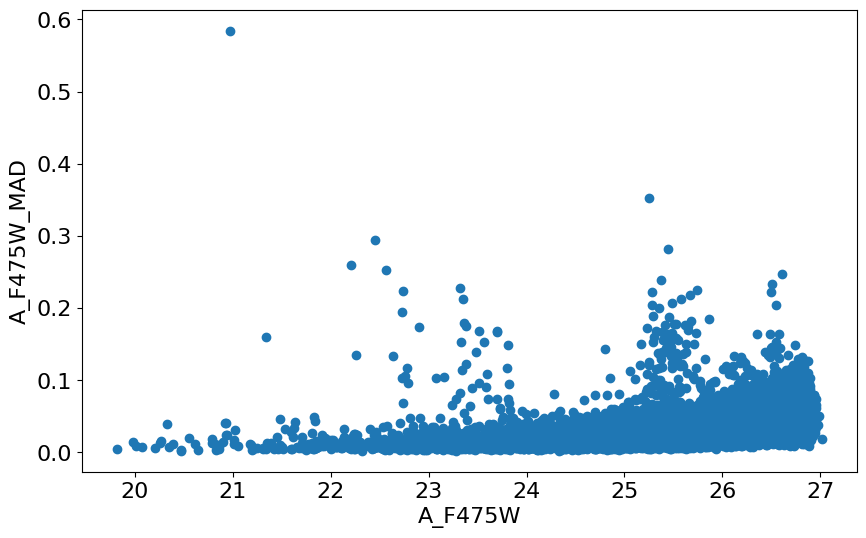

In [8]:
plt.rcParams.update({'font.size': 16})
plt.figure(1,(10,6))
plt.scatter(HSC_results['a_f475w'], HSC_results['a_f475w_mad'])
plt.xlabel('A_F475W')
plt.ylabel('A_F475W_MAD')


 matchid       matchra            matchdec      targetname numimages numvisits      a_f475w          a_f475w_mad     a_f475w_n
                 deg                deg                                               mag                mag                  
--------- ------------------ ------------------ ---------- --------- --------- ------------------ ------------------ ---------
102334412 16.130003898898327 2.1655152822114365     IC1613        26        14 20.970849990844727 0.5844001770019531        12


Text(0, 0.5, 'A_F475W')

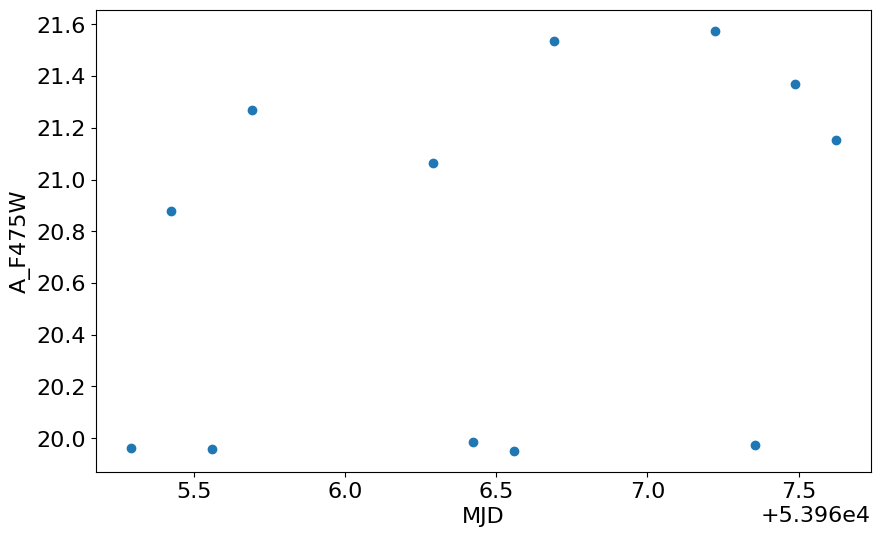

In [9]:
madvalues = HSC_results['a_f475w_mad']
i = np.argmax(madvalues)
print()
print(HSC_results[i])

matchid = HSC_results['matchid'][i]
details = HSC_service.run_async("""
SELECT SourceID, ImageID, SourceRA, SourceDec, D, Filter, Detector, MagAper2, StartMJD
FROM dbo.DetailedCatalog
WHERE 
   MatchID={}
   AND Detector='ACS/WFC' AND Filter='F475W' AND Det='Y'
ORDER BY StartMJD
""".format(matchid))
HSC_details = details.to_table()
HSC_details

plt.rcParams.update({'font.size': 16})
plt.figure(1,(10,6))
plt.scatter(HSC_details['StartMJD'], HSC_details['MagAper2'])
plt.xlabel('MJD')
plt.ylabel('A_F475W')

***
### Use Case: Create a color magnitude diagram for the Small Magellanic Cloud

For another example of using data from a TAP service, we start by doing a search around the SMC with a .25 degree radius for objects with ACS F555W and F814W measurements. HSC TAP will limit us to 100k responses by default. Note this is a large query that can take over a minute to run. See <a href="http://archive.stsci.edu/hst/hsc/help/use_case_2_v3.html" target="_blank">HSC Use Case 2</a> for more details.

Since our query exceeds the 100k response limit, we will get a warning that we are only seeing a partial result set. This partial set is sufficient for our purposes, so you can ignore it!

In [10]:
t0 = time.time()

results = HSC_service.run_async("""
SELECT MatchID, MatchRA, MatchDec, CI, A_F555W, A_F814W
FROM dbo.SumMagAper2CatView
WHERE A_F555W_N > 0 and A_F814W_N > 0
    AND CONTAINS(POINT('ICRS', MatchRA, MatchDec),CIRCLE('ICRS',13.1866,-72.8286,0.25))=1
   """)
HSC_results = results.to_table()
print("Query completed in {:.1f} sec".format(time.time()-t0))
HSC_results

Query completed in 66.8 sec


matchid,matchra,matchdec,ci,a_f555w,a_f814w
,deg,deg,mag,mag,mag
int64,float64,float64,float64,float64,float64
87193895,13.024000412138577,-72.92968859326582,1.443580271285257,24.840599060058594,24.58449935913086
35773699,13.025035586383748,-72.9299794739034,1.027870362187609,24.61240005493164,24.349300384521484
104017528,13.023555729947981,-72.9297926015843,1.0253703888551688,21.873899459838867,22.162900924682617
40535007,13.0257520380231,-72.93018196050252,1.4502315057648554,25.07379913330078,24.825300216674805
61032592,13.02421440278526,-72.93009558926467,1.5189506389476632,22.529699325561523,22.386699676513672
89324003,13.02272444537175,-72.92990471713435,1.0160493629950065,24.373300552368164,24.10099983215332
101057597,13.026053482371552,-72.93037135486455,1.0277777910232544,25.468599319458008,25.322099685668945
80208700,13.024679741921718,-72.93025288056081,0.9643518814334162,25.877300262451172,25.44540023803711


Next, plot the color-magnitude diagram for the ~100k points retrieved from the database. This uses kernel density estimate for the crowded plot. As a preview for the demo, we are only working with 1/25th of the data so that the notebook executes quickly. You can switch the commented-out lines to call gaussian_kde for the full plot, which can take a few minutes to complete.

In [11]:
f555w = HSC_results['a_f555w']
f814w = HSC_results['a_f814w']
VminusI = f555w-f814w
CI = HSC_results['ci']
w = np.where((CI>0.9) & (CI<1.6) & (VminusI > -1.5) & (VminusI < 1.5))
print(len(w[0]),"points remaining after CI and V-I filtering")

# Calculate the point density
x = np.array(VminusI[w])
y = np.array(f555w[w])
xy = np.vstack([x,y])

t0 = time.time()

z = gaussian_kde(xy[:, ::25])(xy) #to do the KDE on only the full dataset, comment out this and uncomment below:
#z = gaussian_kde(xy)(xy) #uncomment this line to do the KDE on the full dataset

print("kde took {:.1f} sec".format(time.time()-t0))

87914 points remaining after CI and V-I filtering


kde took 2.9 sec


Text(0.17, 0.93, '87914 stars in SMC')

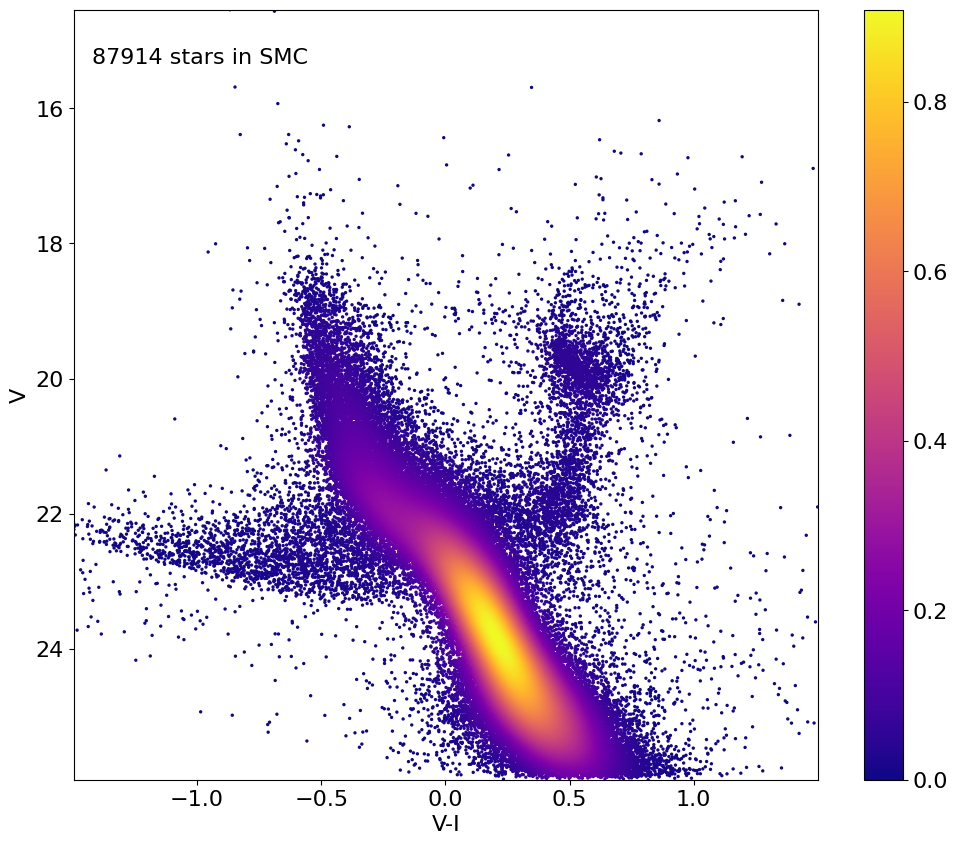

In [12]:
# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

plt.rcParams.update({'font.size': 16})
plt.figure(1,(12,10))
plt.scatter(x, y, c=z, s=2, cmap='plasma')
plt.autoscale(tight=True)
plt.xlabel('V-I')
plt.ylabel('V')
plt.gca().invert_yaxis()
plt.colorbar()
plt.text(.17,.93,'{:d} stars in SMC'.format(len(x)),
       horizontalalignment='center',
       transform=plt.gca().transAxes)
#plt.savefig("smc_colormag.png")

***
# Additional Resources


## Table Access Protocol 
* IVOA standard for RESTful web service access to tabular data
* http://www.ivoa.net/documents/TAP/

## Hubble Source Catalog v3
* Catalog created at MAST by combining the tens of thousands of visit-based source lists in the Hubble Legacy Archive (HLA) into a single master catalog. 
* https://archive.stsci.edu/hst/hsc/

## Astronomical Query Data Language (2.0)
* IVOA standard for querying astronomical data in tabular format, with geometric search support
* http://www.ivoa.net/documents/latest/ADQL.html

## PyVO
* an affiliated package for astropy
* find and retrieve astronomical data available from archives that support standard IVOA virtual observatory service protocols.
* https://pyvo.readthedocs.io/en/latest/index.html

***

## About this Notebook
**Authors:** Rick White & Theresa Dower, STScI Archive Scientist & Software Engineer. Additional edits by Thomas Dutkiewicz.

**Last Updated:** May 2024

***

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="STScI logo" width="200px"/> 